In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt  
import matplotlib
import numpy as np
import urllib
from scipy.stats import pearsonr
import sys
import math

In [2]:
allindicators_wdtmonth_weak = pd.read_csv('allindicators_wdtmonth_weak.csv',usecols=[0,1,2,3,4,5,6],names=['revContributor','wdtmonth','i1','i2','i3','i4','i5'])
allindicators_wdtmonth_power = pd.read_csv('allindicators_wdtmonth_power.csv',usecols=[0,1,2,3,4,5,6],names=['revContributor','wdtmonth','i1','i2','i3','i4','i5'])
allindicators_wdtmonth = pd.concat([allindicators_wdtmonth_weak,allindicators_wdtmonth_power])

In [3]:
len(allindicators_wdtmonth.revContributor.unique())

139549

In [4]:
allindicators_session_weak = pd.read_csv('allindicators_session_weak.csv',usecols=[0,1,2,3,4,5,6],names=['revContributor','session','i1','i2','i3','i4','i5'])
allindicators_session_power = pd.read_csv('allindicators_session_power.csv',usecols=[0,1,2,3,4,5,6],names=['revContributor','session','i1','i2','i3','i4','i5'])
allindicators_session = pd.concat([allindicators_session_weak,allindicators_session_power]).sort_values(by=['revContributor','wdtmonth'])

In [5]:
allindicators_wdtmonth_ge = allindicators_wdtmonth.groupby(by=['revContributor']) 
allindicators_session_ge = allindicators_session.groupby(by=['revContributor'])

In [26]:
def ransac(data,model,n,k,t,d,debug=False,return_all=False):
    """fit model parameters to data using the RANSAC algorithm
    
This implementation written from pseudocode found at
http://en.wikipedia.org/w/index.php?title=RANSAC&oldid=116358182

{{{
Given:
    data - a set of observed data points
    model - a model that can be fitted to data points
    n - the minimum number of data values required to fit the model
    k - the maximum number of iterations allowed in the algorithm
    t - a threshold value for determining when a data point fits a model
    d - the number of close data values required to assert that a model fits well to data
Return:
    bestfit - model parameters which best fit the data (or nil if no good model is found)
iterations = 0
bestfit = nil
besterr = something really large
while iterations < k {
    maybeinliers = n randomly selected values from data
    maybemodel = model parameters fitted to maybeinliers
    alsoinliers = empty set
    for every point in data not in maybeinliers {
        if point fits maybemodel with an error smaller than t
             add point to alsoinliers
    }
    if the number of elements in alsoinliers is > d {
        % this implies that we may have found a good model
        % now test how good it is
        bettermodel = model parameters fitted to all points in maybeinliers and alsoinliers
        thiserr = a measure of how well model fits these points
        if thiserr < besterr {
            bestfit = bettermodel
            besterr = thiserr
        }
    }
    increment iterations
}
return bestfithttp://143.167.102.51:8888/edit/ransac.py
}}}
"""
    iterations = 0
    bestfit = None
    bestintercept = None
    bestr2 = None
    bestslope = None
    besterr = numpy.inf
    best_inlier_idxs = None
    while iterations < k:
        maybe_idxs, test_idxs = random_partition(n,data.shape[0])
        maybeinliers = data[maybe_idxs,:]
        test_points = data[test_idxs]
        tempfit,slope,intercept,r2,temperr = model.fit(maybeinliers)
        test_err = model.get_error( test_points, slope,intercept)
        #if len(test_err) == 0:
            #print("Is the data big enough?")
            #print(maybeinliers,test_points, maybemodel,data)
        #    test_err = numpy.inf
        #    also_idxs = []
        #else:
        also_idxs = test_idxs[test_err < t] # select indices of rows with accepted points
        alsoinliers = data[also_idxs,:]
        if debug:
            print(test_err)
            print('test_err.min()',test_err.min())
            print('test_err.max()',test_err.max())
            print('numpy.mean(test_err)',numpy.mean(test_err))
            #print('iteration %d:len(alsoinliers) = %d'%(iterations,len(alsoinliers)))
        if len(alsoinliers) > d:
            #print("d passed")
            betterdata = numpy.concatenate( (maybeinliers, alsoinliers) )
            betterfit,betterslope,betterintercept,betterr2,betterttemperr = model.fit(betterdata)
            better_errs = model.get_error( betterdata, betterslope, betterintercept)
            thiserr = numpy.mean( better_errs )
            if thiserr < besterr:
                bestfit = betterfit
                bestslope = betterslope
                bestintercept = betterintercept
                bestr2 = betterr2
                #print("entered!",thiserr)
                besterr = thiserr
                best_inlier_idxs = numpy.concatenate( (maybe_idxs, also_idxs) )
        iterations+=1
    if bestfit is None:
        pass
       # print("did not meet fit acceptance criteria")
    if return_all:
        return bestfit, {'inliers':best_inlier_idxs}, bestslope, bestr2, bestintercept
    else:
        return bestfit

def random_partition(n,n_data):
    """return n random rows of data (and also the other len(data)-n rows)"""
    all_idxs = numpy.arange( n_data )
    numpy.random.shuffle(all_idxs)
    idxs1 = all_idxs[:n]
    idxs2 = all_idxs[n:]
    return idxs1, idxs2

class LinearLeastSquaresModel:
    """linear system solved using linear least squares

    This class serves as an example that fulfills the model interface
    needed by the ransac() function.
    
    """
    def __init__(self,input_columns,output_columns,debug=False):
        self.input_columns = input_columns
        self.output_columns = output_columns
        self.debug = debug
    def fit(self, data):
        A = numpy.vstack([data[:,i] for i in self.input_columns]).T
        B = numpy.vstack([data[:,i] for i in self.output_columns]).T
        linfit = scipy.stats.linregress(A.flatten().T,B.flatten().T)
        x = linfit[0]*B.flatten() + linfit[1]
        return x,linfit[0],linfit[1],linfit[2]**2,linfit[4]
    def get_error( self, data, slope, intercept):
        A = numpy.vstack([data[:,i] for i in self.input_columns]).T
        B = numpy.vstack([data[:,i] for i in self.output_columns]).T
        B_fit = A.flatten()*slope + intercept
        err_per_point = numpy.sum((B-B_fit)**2,axis=1) # sum squared error per row
        return err_per_point
        


def R2(x,y,slope):
    
    if slope is None:
        return None
    # compute goodness of a liner fit
    ss_res = np.sum((y - x*slope ) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2
    
    
def compute_slope(x,y,n=50,k=1000,t=7e3,d=300,debug=False):
    
    if len(x)<3:
        return pd.Series({'slope':None,'R2':None,'intercept':None})
    else:
        #print("before ransac",np.transpose(np.vstack((x,y))))
        ransac_fit= ransac(np.transpose(np.vstack((x,y))),LinearLeastSquaresModel([0],[1],debug=False),
                                     n, k, t, d, # misc. parameters
                                     debug=debug,return_all=True)
        idx = ransac_fit[1]['inliers']
        #print(ransac_fit)
        if ransac_fit[0] is None:
            return pd.Series({'slope':None,'R2':None, 'intercept':None})
        #res = np.zeros(ransac_fit[0].shape)
        #for i,fitvalue in enumerate(ransac_fit[0]):
        
        #    try:
        #        res[idx[i]] = fitvalue
        #    except:
        #        print(np.vstack((x,y)),ransac_fit[0].shape,ransac_fit)
        #        assert False
        r2 = ransac_fit[3]
        slope = ransac_fit[2]
        intercept = ransac_fit[4]
        #r2 = R2(x,y,res)
        #if ransac_fit is not None:
        #    ransac_fit = ransac_fit[0][0]
        tupleresult = slope, r2,intercept
    
        return pd.Series({'slope':tupleresult[0],'R2':tupleresult[1],'intercept':tupleresult[2]})


In [41]:
allindicators_session_ge.get_group(1.0)['session'].values

array([ 100.,  103.,  105.,   10.,  110.,  112.,  115.,  118.,   11.,
        121.,  122.,  123.,  124.,  125.,  126.,  127.,  128.,  129.,
         12.,  130.,  131.,  132.,  134.,  136.,  137.,  138.,   13.,
        141.,  142.,  144.,  146.,  158.,  159.,  161.,  163.,  164.,
        165.,  168.,  169.,  171.,  172.,   17.,  180.,  181.,  182.,
        183.,  184.,  185.,  187.,  188.,  189.,  190.,  191.,  192.,
        194.,  196.,  197.,  198.,  199.,   19.,  201.,  203.,  204.,
        206.,  207.,  209.,   20.,  210.,  211.,  212.,  213.,  214.,
        215.,   21.,  220.,  221.,  222.,  223.,  224.,  225.,  228.,
        229.,  230.,  231.,  232.,  233.,  234.,  238.,  239.,  240.,
        241.,  242.,  243.,  244.,  245.,  246.,  247.,  248.,  249.,
        250.,  252.,  253.,  255.,  256.,  257.,  258.,  259.,   25.,
        260.,  261.,  262.,  264.,  265.,  267.,  271.,  272.,  276.,
        278.,   27.,  288.,  289.,   28.,  291.,  293.,  294.,  296.,
        297.,  298.,

In [85]:
allindicators_session[allindicators_session['revContributor'].\
                      isin(allindicators_session['revContributor'].\
                           unique()[:10])].groupby('revContributor').\
apply((lambda x: compute_slope(np.array(range(len(x['session'].values))),\
                               x['i1'].values,10,1000,1000,10,False)))

,R2,intercept,slope
revContributor,,,
27.0,0.000957,1.806717,-0.001155
57.0,0.081261,1.900646,0.001482
160.0,0.004441,1.007218,-0.000017
161.0,0.004631,1.124254,0.001159
192.0,0.012616,1.563157,-0.002067
272.0,0.018425,1.173984,-0.001352
312.0,0.008107,1.349274,-0.001295
382.0,0.002920,1.417250,0.001220
385.0,0.001559,1.360294,-0.000345


In [58]:
np.sort(np.array([1,4,2,1,6]))

array([1, 1, 2, 4, 6])

In [65]:
allindicators_session[allindicators_session['revContributor'].isin(allindicators_session['revContributor'].unique()[:2])].\
sort_values(by=['revContributor','session']).groupby('revContributor').get_group(27.0)

,revContributor,session,i1,i2,i3,i4,i5
0,27.0,1006.0,3.0,3.0,1.0,182.0,0.306099
15666,27.0,1057.0,2.0,2.0,1.0,16.0,0.500000
18684,27.0,1066.0,4.0,2.0,2.0,65.0,0.375000
18685,27.0,1067.0,1.0,1.0,1.0,0.0,0.000000
24607,27.0,1088.0,1.0,1.0,1.0,0.0,0.000000
50728,27.0,1107.0,1.0,1.0,1.0,0.0,0.000000
53587,27.0,1117.0,2.0,2.0,1.0,34.0,0.000000
59208,27.0,1131.0,7.0,7.0,1.0,6112.0,0.000000
64725,27.0,1157.0,2.0,2.0,1.0,48.0,0.500000
64726,27.0,1158.0,1.0,1.0,1.0,0.0,0.000000


revContributor
27.0     Axes(0.125,0.125;0.775x0.775)
57.0     Axes(0.125,0.125;0.775x0.775)
160.0    Axes(0.125,0.125;0.775x0.775)
161.0    Axes(0.125,0.125;0.775x0.775)
192.0    Axes(0.125,0.125;0.775x0.775)
dtype: object

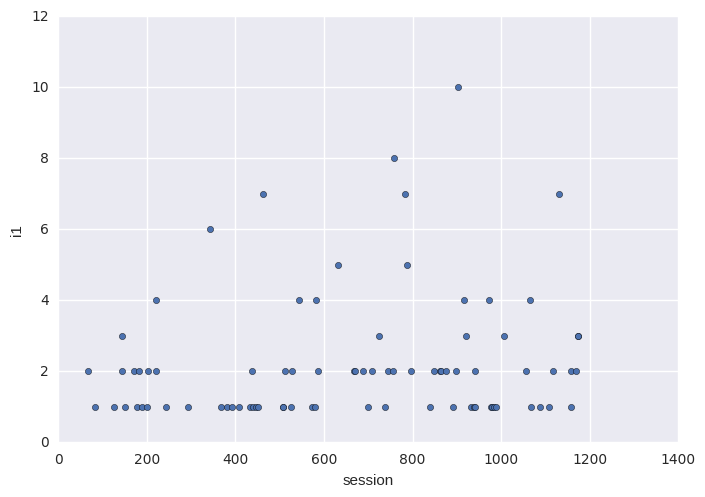

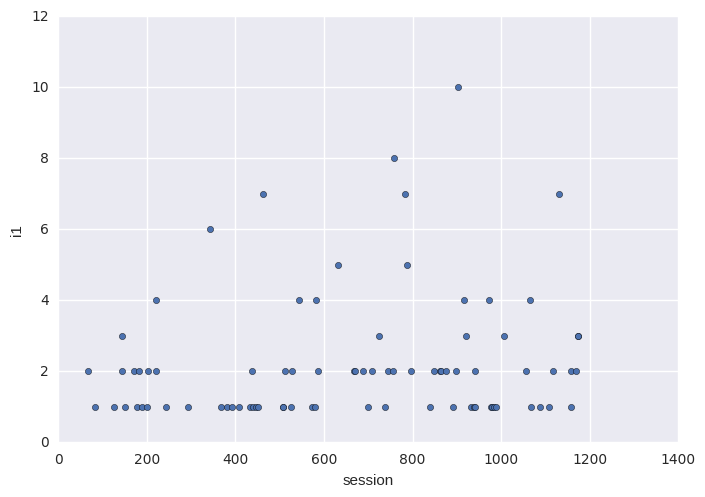

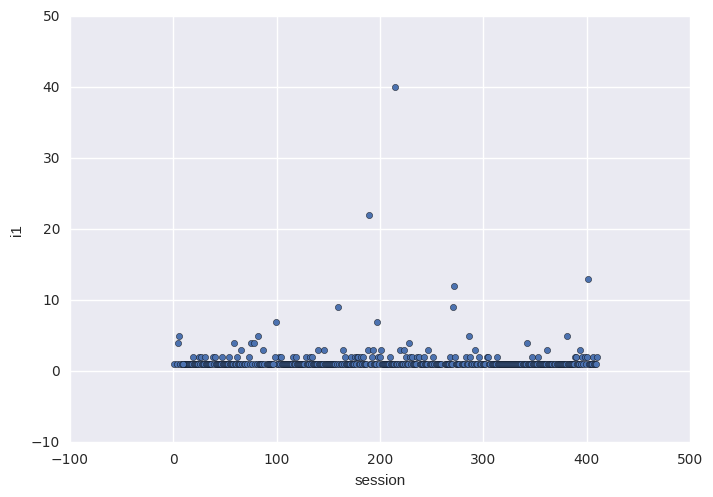

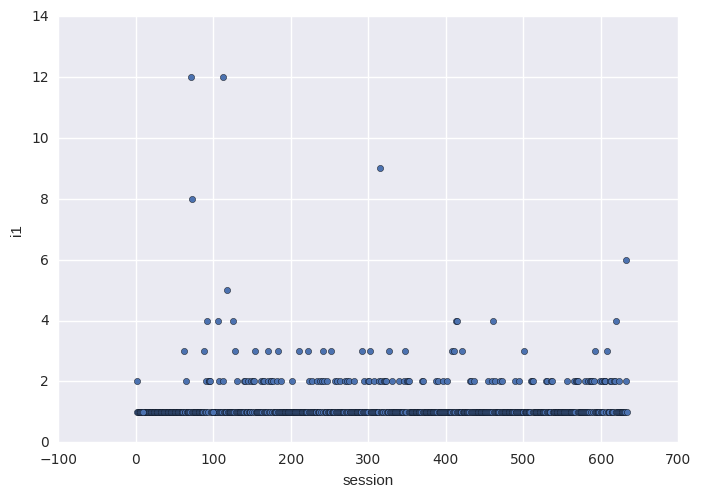

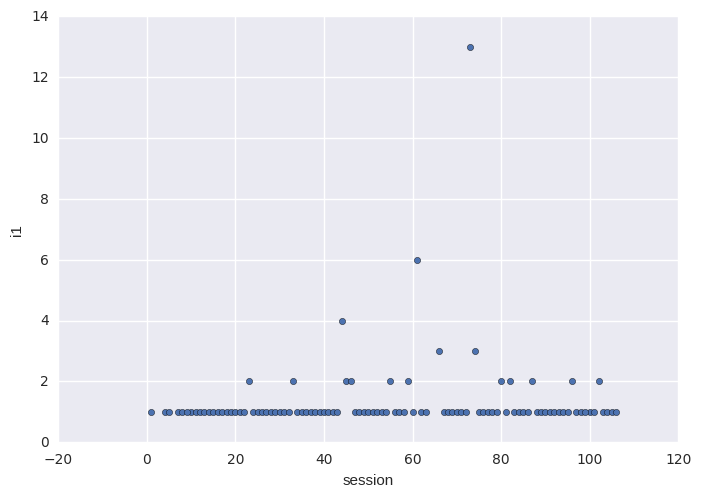

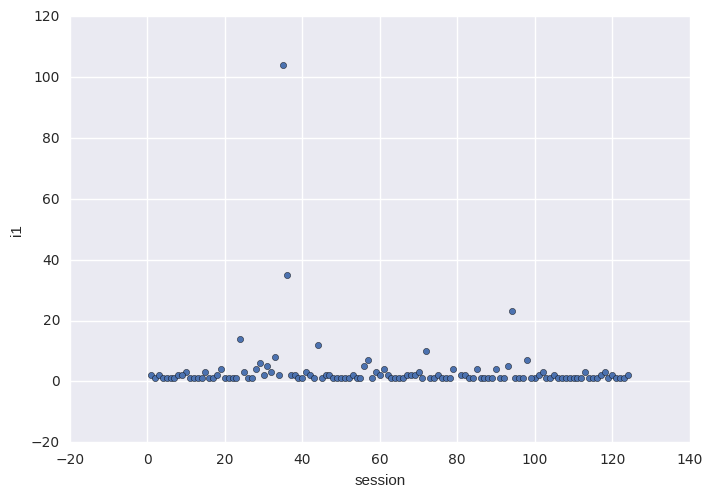

In [55]:
allindicators_session[allindicators_session['revContributor'].isin(allindicators_session['revContributor'].unique()[:5])].groupby('revContributor').plot.scatter(x='session',y='i1')

[0 1 2 3 4 5 6] [6 5 4 3 2 1 0]


/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


R2      -1.0
slope   -1.0
dtype: float64


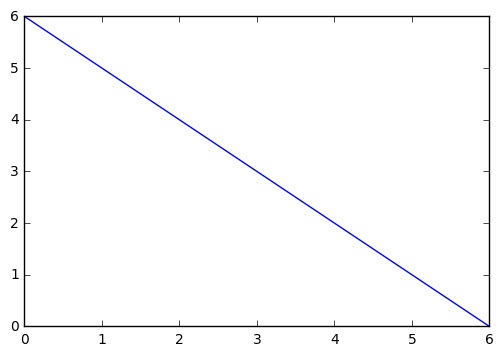

In [7]:
a = np.array([0,1,2,3,4,5,6])
#b = np.array(list(range(40))) + 40*np.random.rand(40)
b = np.array([6,5,4,3,2,1,0])
print(a.flatten(),b.flatten())
aa = compute_slope(a,b,n=2,k=1000,t=100000000000,d=0,debug=False)
plt.plot(a,b)
print(aa)

In [8]:
a = np.array([1,2,3,4])
idx = np.array([0,2,1,3])
a[idx]

array([1, 3, 2, 4])

In [9]:
def test():
    # generate perfect input data

    n_samples = 500
    n_inputs = 1
    n_outputs = 1
    A_exact = 20*numpy.random.random((n_samples,n_inputs) )
    perfect_fit = 2 # 60*numpy.random.normal(size=(n_inputs,n_outputs) ) # the model
    B_exact = scipy.dot(A_exact,perfect_fit)
    assert B_exact.shape == (n_samples,n_outputs)

    # add a little gaussian noise (linear least squares alone should handle this well)
    A_noisy = A_exact + numpy.random.normal(size=A_exact.shape )
    B_noisy = B_exact + numpy.random.normal(size=B_exact.shape )

    if 1:
        # add some outliers
        n_outliers = 10
        all_idxs = numpy.arange( A_noisy.shape[0] )
        numpy.random.shuffle(all_idxs)
        outlier_idxs = all_idxs[:n_outliers]
        non_outlier_idxs = all_idxs[n_outliers:]
        A_noisy[outlier_idxs] =  20*numpy.random.random((n_outliers,n_inputs) )
        B_noisy[outlier_idxs] = 50*numpy.random.normal(size=(n_outliers,n_outputs) )

    # setup model

    all_data = numpy.hstack( (A_noisy,B_noisy) )
    input_columns = [0]# list(range(n_inputs)) # the first columns of the array
    output_columns = [1]# [n_inputs+i for i in range(n_outputs)] # the last columns of the array
    debug = False
    model = LinearLeastSquaresModel(input_columns,output_columns,debug=debug)

    linear_fit,resids,rank,s = scipy.linalg.lstsq(all_data[:,input_columns],
                                                  all_data[:,output_columns])

    # run RANSAC algorithm
    ransac_fit, ransac_data = ransac(np.hstack((A_noisy,B_noisy)),LinearLeastSquaresModel([0],[1],debug=False),
                                     50, 1000, 7e3, 300, # misc. parameters
                                     debug=False,return_all=True)
    if 1:
        import pylab

        sort_idxs = numpy.argsort(A_exact[:,0])
        A_col0_sorted = A_exact[sort_idxs] # maintain as rank-2 array

        if 1:
            pylab.plot( A_noisy[:,0], B_noisy[:,0], 'k.', label='data' )
            pylab.plot( A_noisy[ransac_data['inliers'],0], B_noisy[ransac_data['inliers'],0], 'bx', label='RANSAC data' )
        else:
            pylab.plot( A_noisy[non_outlier_idxs,0], B_noisy[non_outlier_idxs,0], 'k.', label='noisy data' )
            pylab.plot( A_noisy[outlier_idxs,0], B_noisy[outlier_idxs,0], 'r.', label='outlier data' )
        pylab.plot( A_col0_sorted[:,0],
                    numpy.dot(A_col0_sorted,ransac_fit)[:,0],
                    label='RANSAC fit' )
        pylab.plot( A_col0_sorted[:,0],
                    numpy.dot(A_col0_sorted,perfect_fit)[:,0],
                    label='exact system' )
        pylab.plot( A_col0_sorted[:,0],
                    numpy.dot(A_col0_sorted,linear_fit)[:,0],
                    label='linear fit' )
        pylab.legend()
        pylab.show()
        
        
    
    
    r2 = R2(A_noisy[:],B_noisy[:],ransac_fit)
    
    return ransac_fit[0][0], r2

testdata = allindicators_wdtmonth.sample(1000)
testdata_ge = testdata.groupby(by=['revContributor'])

testdata_ge.apply(lambda x: compute_slope(x['wdtmonth'].values,x['i1'].values,50,1000,7e3,0)) #n=50,k=1000,t=7e3,d=300

In [10]:
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
testdata = allindicators_wdtmonth.sample(n=5000)
testdata_ge = testdata.groupby(by=['revContributor'])
testdata_ge.progress_apply(lambda x: compute_slope(x['wdtmonth'].values,x['i1'].values,1,100,1000,0,False))

0it [00:00, ?it/s]
/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:93: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:94: RuntimeWarning: invalid value encountered in absolute
  prob = 2 * distributions.t.sf(np.abs(t), df)
/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:95: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/ipykernel/__main__.py:96: RuntimeWarning: invalid value encountered in less
4664it [00:03, 1438.17it/s]


,R2,slope
revContributor,,
1.0,None,None
3.0,None,None
27.0,None,None
49.0,None,None
57.0,None,None
86.0,None,None
106.0,None,None
137.0,None,None
159.0,None,None


In [11]:
#data - a set of observed data points
#model - a model that can be fitted to data points
#  n - the minimum number of data values required to fit the model
#   k - the maximum number of iterations allowed in the algorithm
#   t - a threshold value for determining when a data point fits a model
#  d - the number of close data values required to assert that a model fits well to data

#fit,r2 = 
resultfit = allindicators_wdtmonth_ge.progress_apply(lambda x: compute_slope(x['wdtmonth'].values,x['i1'].values,2,10,10000,0,False))

  0%|          | 1/139550 [00:01<45:49:16,  1.18s/it]/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
  1%|          | 745/139550 [00:08<25:18, 91.39it/s]

KeyboardInterrupt: 

In [ ]:
resultfit.describe()

In [ ]:
resultfit.plot.scatter(x='slope',y='R2')

In [ ]:
np.inf

In [ ]:
len(resultfit.dropna())

In [ ]:
compute_slope([1,2,3],[4,5,6],1,1000,1000,0,False)

In [ ]:
2.28*np.array([1,2,3])

In [ ]:
plt.plot([1,2,3],[4,5,6])

In [ ]:
result_session = {}
for ll in ['i1','i2','i3','i4','i5']:
    result_session[ll] = allindicators_session_ge.apply(lambda x: compute_slope(x['session'].values,x[ll].values,1,10,10000,0,False))
    print(result_session)
result_session[ll].to_csv('ransac_session.csv',index=False)    

In [ ]:

from joblib import Parallel, delayed
a = Parallel(n_jobs=5,  verbose=2,backend="multiprocessing")(delayed(allindicators_session_ge.apply(lambda x: compute_slope(x['session'].values,x[ll].values,1,1,10000,0,False)))(ll) for ll in ['i1','i2','i3','i4','i5'])
#result_array_session = np.ndarray(shape=(5,1))
#result_array_session = Parallel(n_jobs=5, verbose=2, backend="multiprocessing")(map(delayed(h), result_array_session))

In [ ]:
result_wdtmonth= {}
for ll in ['i1','i2','i3','i5']:
    result_wdtmonth[ll] = allindicators_wdtmonth_ge.apply(lambda x: compute_slope(x['wdtmonth'].values,x[ll].values,1,10,10000,0,False))
    print(result_wdtmonth)
    result_wdtmonth[ll].to_csv('ransac_wdtmonth_'+ll+'_.csv',index=False)    

In [ ]:
test =allindicators_wdtmonth[0:5]
test.to_csv('ransac_test_result.csv',index=False)

In [ ]:
result_wd


## Reading the generated ransac data 

In [121]:
sessionransac = pd.read_pickle('session_ransac_10_4.pkl')
monthransac = pd.read_pickle('month_ransac_10_4.pkl')
len(pd.read_pickle('month_ransac_10_4.pkl').dropna())

146218

In [13]:
monthransac.head()

R2  intercept     slope
   revContributor                               
i1 1.0             0.061731   5.669886  0.102445
   2.0             0.145022   9.380709 -0.207094
   3.0             0.017538   3.721795  0.035094
   4.0             0.007509   1.695035  0.010638
   7.0                  NaN        NaN       NaN

In [15]:
sessionransac.tail(10)

R2  intercept  slope
   revContributor                      
i5 2720535.0      NaN        NaN    NaN
   2720537.0      NaN        NaN    NaN
   2720543.0      NaN        NaN    NaN
   2720555.0      NaN        NaN    NaN
   2720557.0      NaN        NaN    NaN
   2720560.0      NaN        NaN    NaN
   2720567.0      NaN        NaN    NaN
   2720571.0      NaN        NaN    NaN
   2720581.0      NaN        NaN    NaN
   2720602.0      NaN        NaN    NaN

In [16]:
print(len(sessionransac.index.unique()))
i1 = sessionransac.loc[pd.IndexSlice['i1', :]]
i1_adhoc = i1
i1_adhoc['correct_R2'] = i1_adhoc['R2']**2
print(len(sessionransac.loc[pd.IndexSlice['i1', :]]))

697745
139549


In [17]:
i1session = sessionransac.loc[pd.IndexSlice['i1', :]]
i1month = monthransac.loc[pd.IndexSlice['i1', :]]


#i1month_adhoc = i1month
#i1month_adhoc['correct_R2'] = i1month_adhoc['R2']**2

#i1session_adhoc = i1session
#i1session_adhoc['correct_R2'] = i1session_adhoc['R2']**2

In [18]:
users_notools_items = pd.read_csv('userdata_2305_notoolsitemsdata.csv', usecols=[0,1,2,3,4,5])
#revContributor	editCount	lifespan	start	end	gone


In [19]:
i1month.describe()

,R2,intercept,slope
count,36122.000000,36122.000000,36122.000000
mean,0.240398,9.463964,-0.077281
std,0.279828,119.149033,4.030076
min,0.000000,-4820.000000,-328.500000
25%,0.021068,0.782142,-0.133333
50%,0.124236,2.796362,0.000000
75%,0.366070,9.047440,0.092998
max,1.000000,10674.333333,158.500000


In [20]:
dfu = users_notools_items.set_index(['revContributor'])
dfu.index = dfu.index.map(float)
i1a = i1month.reset_index()
dfi1 = i1a.set_index(['revContributor'])
dfi1.index = dfi1.index.map(float)

dfui1 = pd.concat([dfu,dfi1],axis=1)

In [21]:
dfui1.head()

,editCount,lifespan,start,end,gone,R2,intercept,slope
1.0,1901,44.333333,2012-11-01 00:21:16,2016-06-23 14:46:51,0,0.061731,5.669886,0.102445
2.0,1049,41.700000,2012-10-29 17:41:05,2016-04-03 12:21:35,0,0.145022,9.380709,-0.207094
3.0,340,39.900000,2013-03-21 23:43:18,2016-07-01 15:10:56,0,0.017538,3.721795,0.035094
4.0,266,19.866667,2012-10-31 01:35:44,2014-06-19 05:46:47,1,0.007509,1.695035,0.010638
7.0,1,0.000000,2014-04-28 01:03:37,2014-04-28 01:03:37,1,NaN,NaN,NaN


(-10, 10)

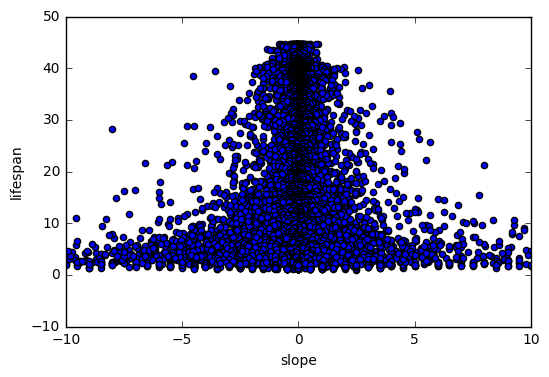

In [22]:
dfui1.plot.scatter(x='slope',y='lifespan')
plt.xlim([-10,10])

In [24]:
import seaborn as sns


In [25]:
dfui1.head()

,editCount,lifespan,start,end,gone,R2,intercept,slope
1.0,1901,44.333333,2012-11-01 00:21:16,2016-06-23 14:46:51,0,0.061731,5.669886,0.102445
2.0,1049,41.700000,2012-10-29 17:41:05,2016-04-03 12:21:35,0,0.145022,9.380709,-0.207094
3.0,340,39.900000,2013-03-21 23:43:18,2016-07-01 15:10:56,0,0.017538,3.721795,0.035094
4.0,266,19.866667,2012-10-31 01:35:44,2014-06-19 05:46:47,1,0.007509,1.695035,0.010638
7.0,1,0.000000,2014-04-28 01:03:37,2014-04-28 01:03:37,1,NaN,NaN,NaN


In [213]:
def scatter_indicators(i,timep,df,xlim1,xlim2,ylim1,ylim2,alpha,goal):
    
    # get only indicators
    idata = df.loc[pd.IndexSlice[i, :]]
    dfu = users_notools_items.set_index(['revContributor'])
    dfu.index = dfu.index.map(float)
    iraw = idata.reset_index()
    dfi= iraw.set_index(['revContributor'])
    dfi.index = dfi.index.map(float)
    
    

    dfui = pd.concat([dfu,dfi],axis=1)
    
    

    #sns.palplot(sns.color_palette("cubehelix", 8))
    # PLOT WITH LIFESPAN LOW
    #highlifespan = dfui.loc[dfui['lifespan'] >30]
    #lowlifespan = dfui.loc[dfui['lifespan'] <=30]
    
  
    if goal == 'editCount':
        dfuilog = dfui[goal].apply(lambda x: np.log(1+x))
        plots= plt.scatter(x=dfui['slope'],y=dfui['intercept'],c=dfuilog,s=15,cmap='BuGn',alpha=alpha,linewidth=0) # slope, 
    # directly with this 
    else:
        plots= plt.scatter(x=dfui['slope'],y=dfui['intercept'],c=dfui[goal],s=15,cmap='BuGn',alpha=alpha,linewidth=0) # slope, 
    # directly with this 

    
    #plt.title("Scatter plot slope, intercept, lifespan for indicator "+i+" and evolution based on "+timep+" .")
    
    plt.xlabel('slope')
    plt.ylabel('intercept') # and R2?!
    
    plt.colorbar(plots)
    if xlim1 is not None and xlim2 is not None:
        plt.xlim([xlim1,xlim2]) #100
    if ylim1 is not None and ylim2 is not None:    
        plt.ylim([ylim1,ylim2]) #1000
        
   
    

    plt.show()    

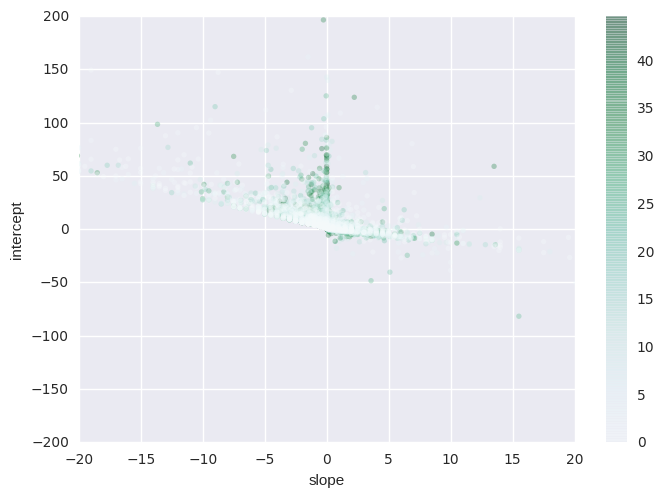

In [212]:
scatter_indicators('i1','session',sessionransac,-20,20,-200,200,0.3,'lifespan')

#scatter_indicators('i1','session',sessionransac,None,None,None,None,0.3,'lifespan')


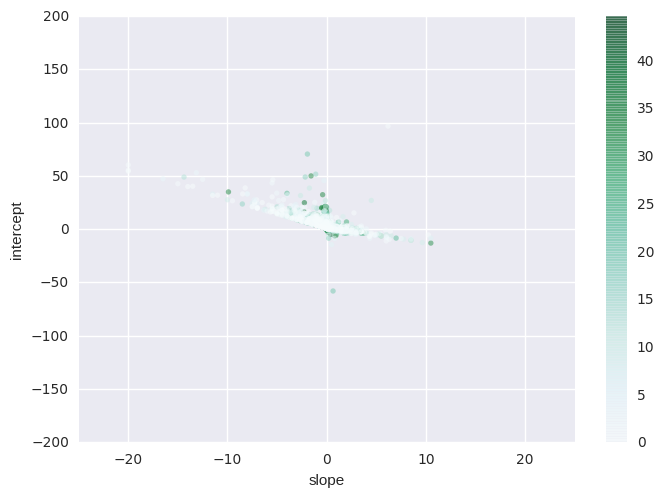

In [186]:
scatter_indicators('i2','session',sessionransac,-20,20,-200,200,0.5,'lifespan')


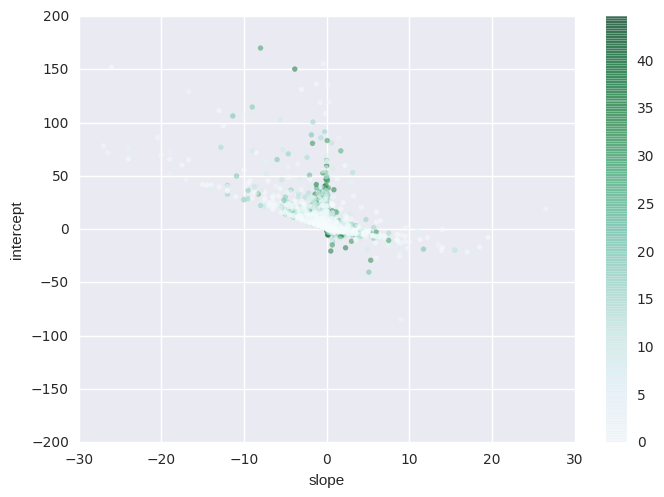

In [187]:
scatter_indicators('i3','session',sessionransac,-30,30,-200,200,0.5,'lifespan')


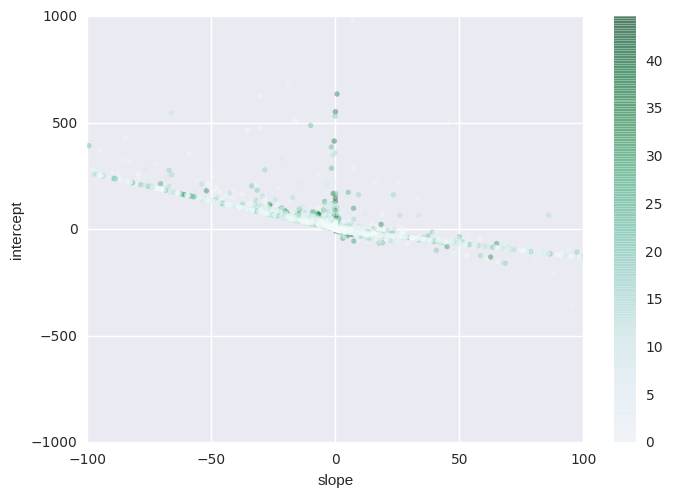

In [188]:
scatter_indicators('i4','session',sessionransac,-100,100,-1000,1000,0.4,'lifespan')


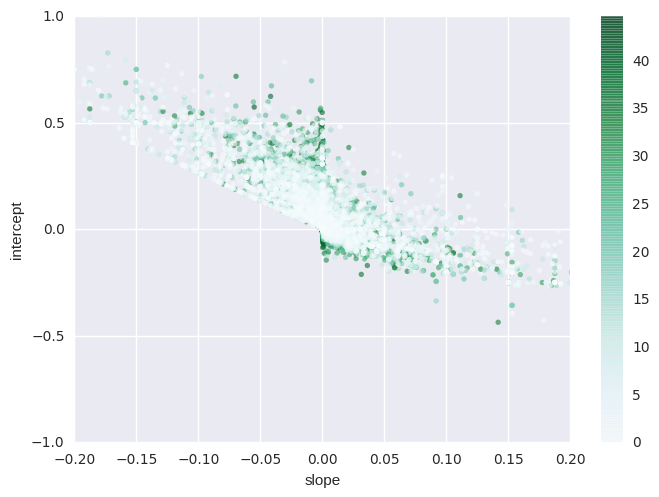

In [223]:
scatter_indicators('i5','session',sessionransac,-0.2,0.2,-1,1,0.6,'lifespan')

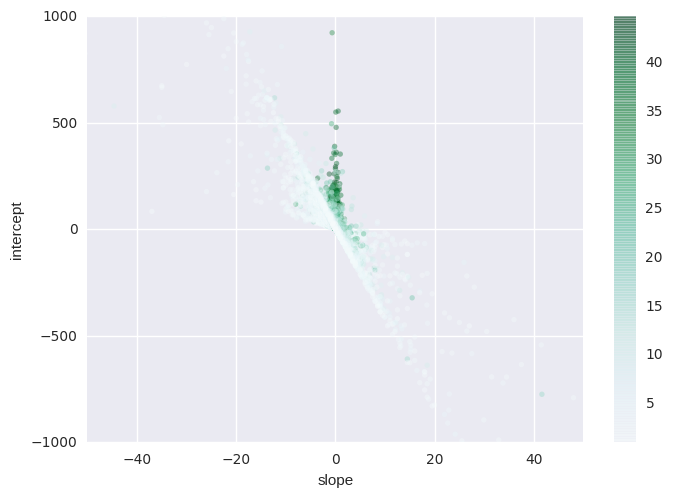

In [190]:
scatter_indicators('i1','wdtmonth',monthransac,-50,50,-1000,1000,0.4,'lifespan')


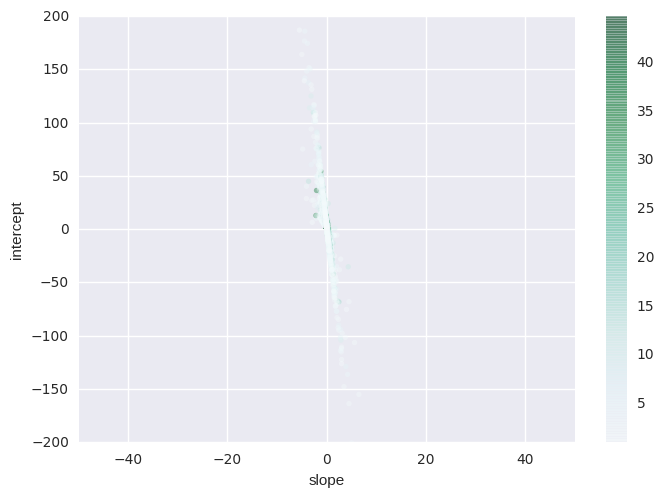

In [191]:
scatter_indicators('i2','wdtmonth',monthransac,-50,50,-200,200,0.4,'lifespan')


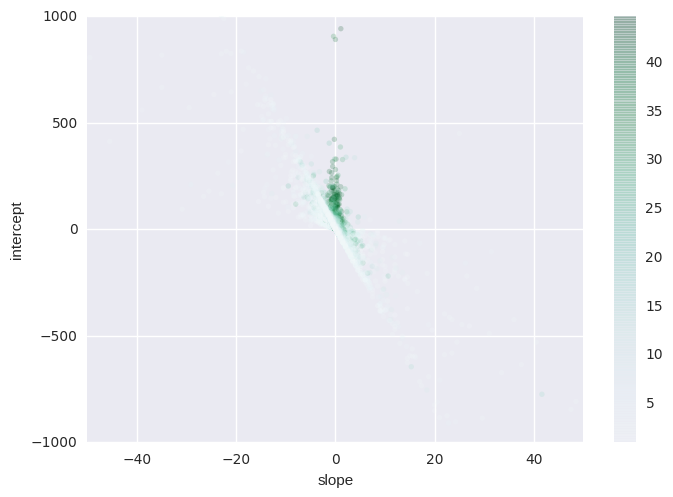

In [192]:
scatter_indicators('i3','wdtmonth',monthransac,-50,50,-1000,1000,0.20,'lifespan')


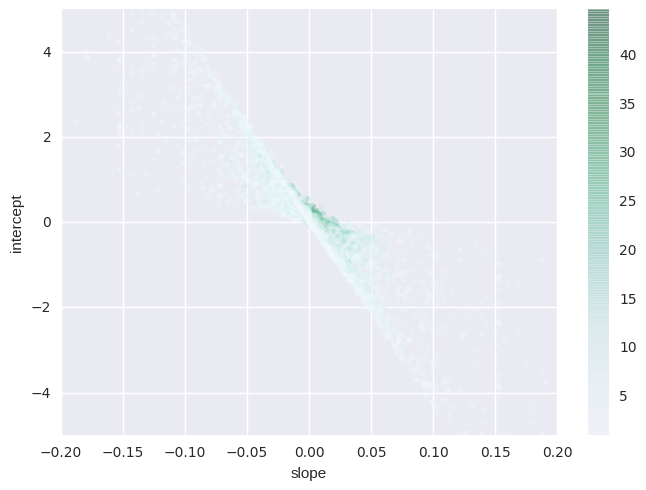

In [224]:
# i4 not applicable
scatter_indicators('i5','wdtmonth',monthransac,-0.2,0.2,-5,5,0.3,'lifespan')

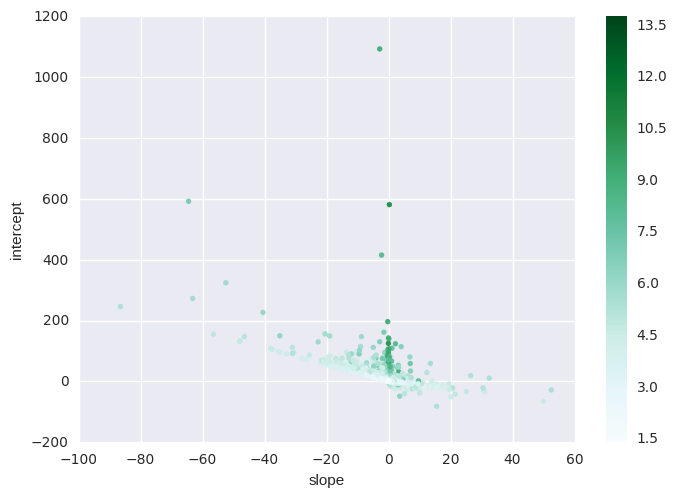

In [214]:
scatter_indicators('i1','session',sessionransac,None,None,None,None,1,'editCount')   # LOG EDIT COUNT!

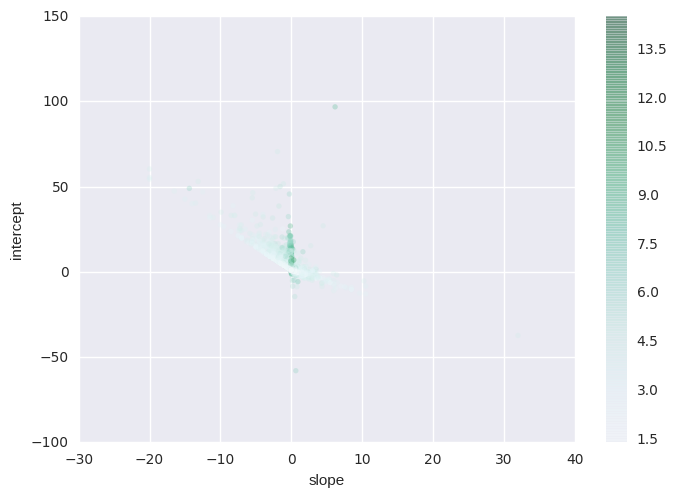

In [215]:
scatter_indicators('i2','session',sessionransac,None,None,None,None,0.3,'editCount')

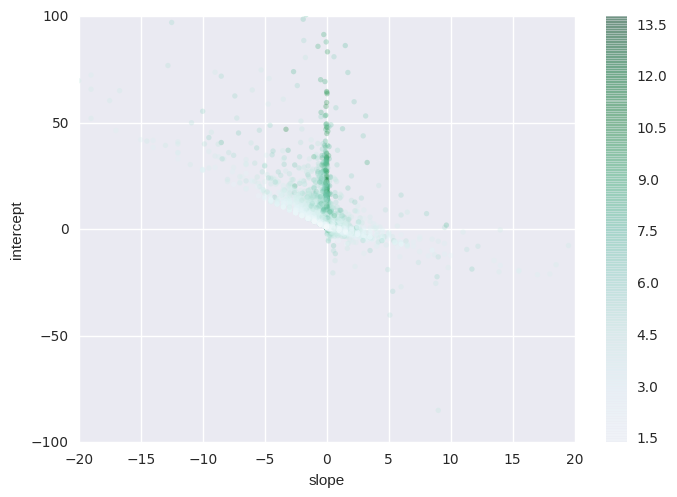

In [216]:
scatter_indicators('i3','session',sessionransac,-20,20,-100,100,0.3,'editCount')

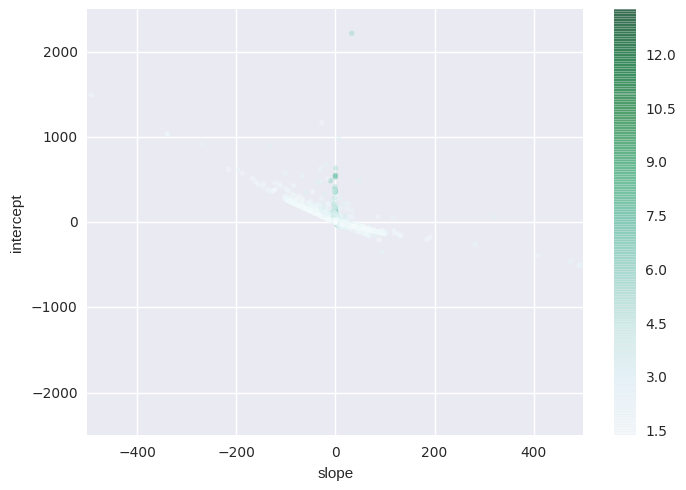

In [227]:
scatter_indicators('i4','session',sessionransac,-500,500,-2500,2500,0.5,'editCount')

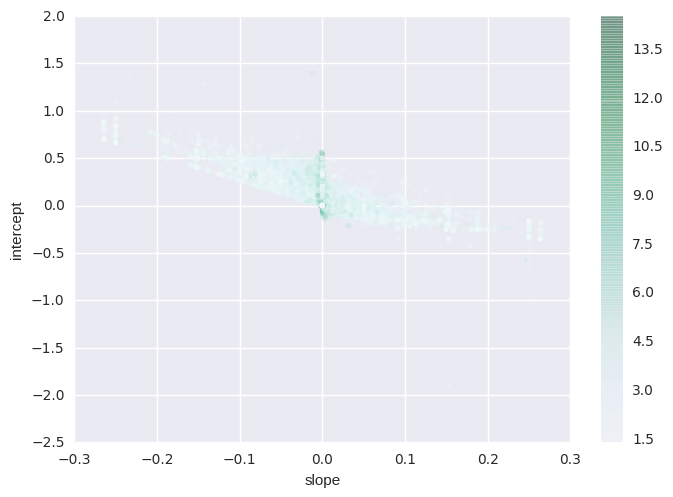

In [218]:
scatter_indicators('i5','session',sessionransac,None,None,None,None,0.3,'editCount')

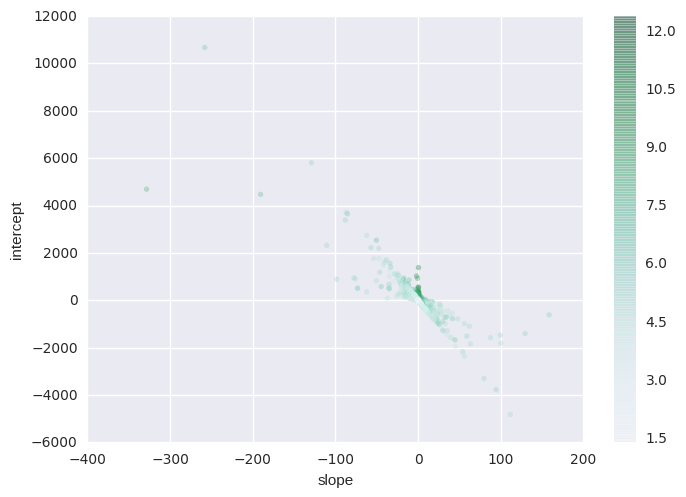

In [219]:
scatter_indicators('i1','wdtmonth',monthransac,None,None,None,None,0.3,'editCount')

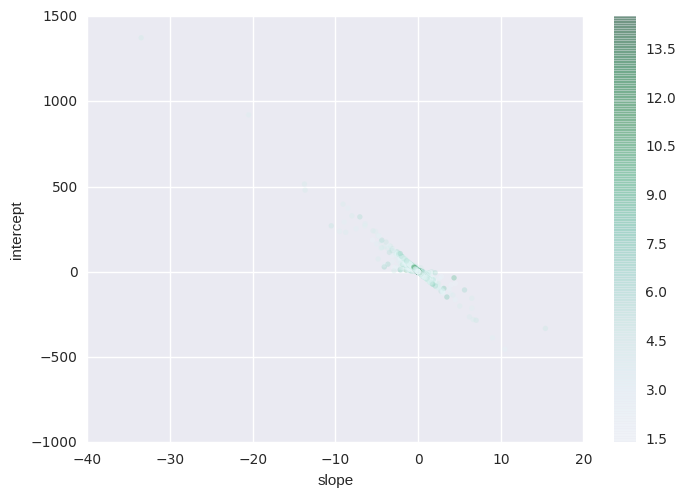

In [220]:
scatter_indicators('i2','wdtmonth',monthransac,None,None,None,None,0.3,'editCount')

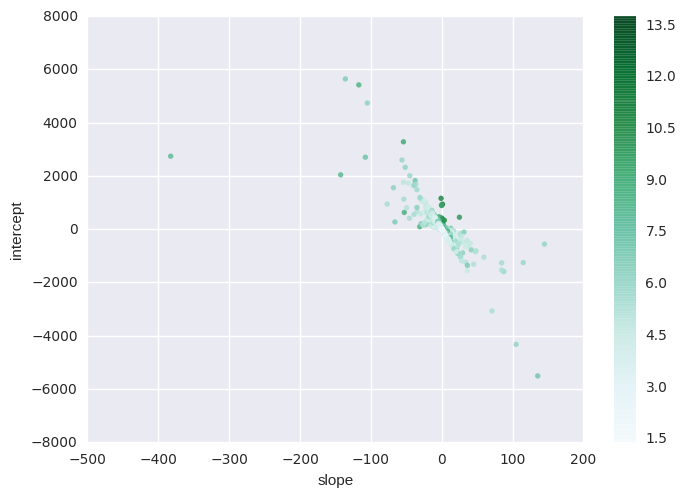

In [229]:
scatter_indicators('i3','wdtmonth',monthransac,None,None,None,None,0.8,'editCount')

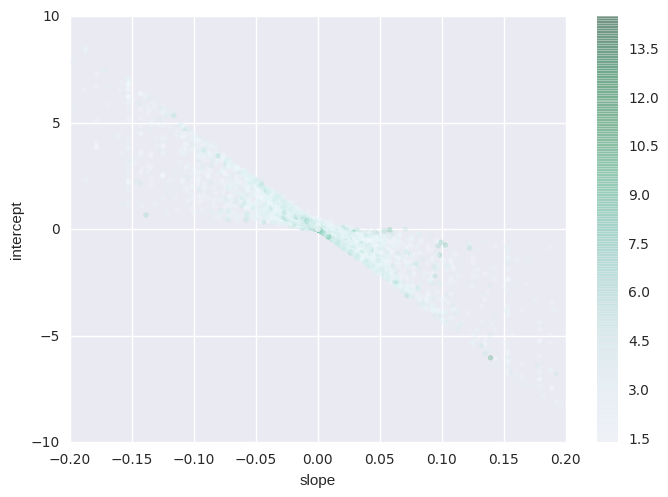

In [222]:
scatter_indicators('i5','wdtmonth',monthransac,-0.2,0.2,-10,10,0.3,'editCount')

In [203]:
plots= plt.scatter(x=d['slope'],y=d['intercept'],c=d['lifespan'],s=15,cmap='BuGn',alpha=0.5,linewidth=0) # slope, 
plt.colorbar(plots)
plt.xlim([-100,100]) #100
plt.ylim([-1000,1000]) #1000

NameError: name 'd' is not defined

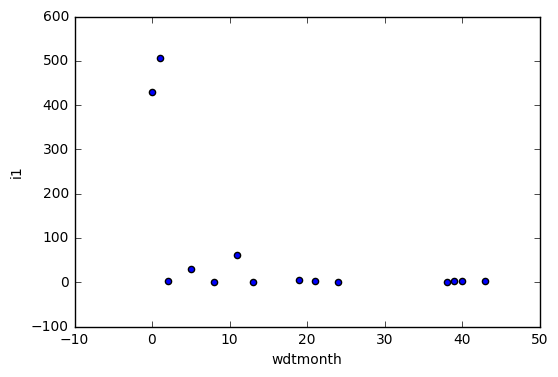

In [624]:
user2 = allindicators_wdtmonth.loc[allindicators_wdtmonth['revContributor']==2]
user2.head()
user2.plot.scatter(x='wdtmonth',y='i1')

In [600]:
sessionransac.head(100)

R2     slope
   revContributor                    
i1 1.0             0.163024  0.001123
   2.0            -0.268520 -0.031655
   3.0            -0.111575 -0.002030
   4.0            -0.671347 -0.212024
   7.0                  NaN       NaN
   9.0            -0.907010 -2.185714
   12.0           -0.042435 -0.001320
   13.0            0.184444  0.001119
   14.0                 NaN       NaN
   15.0            0.000210  0.000008
   16.0           -0.559998 -0.067511
   18.0           -0.030002 -0.019802
   23.0            0.251346  0.066751
   24.0            0.184469  0.006213
   27.0           -0.131470 -0.000328
   31.0            0.164788  0.000887
   39.0            0.010187  0.000014
   45.0            0.190697  0.020824
   48.0            0.302259  0.130169
   49.0            0.103274  0.000099
   51.0                 NaN       NaN
   55.0            0.404520  0.300000
   56.0           -0.046512 -0.000329
   57.0            0.335398  0.005991
   58.0                 NaN       NaN
   61.0           -0.101588 -0.012266
   62.0            0.333987  0.021872
   65.0           -0.358440 -0.023123
   69.0            0.000000  0.000000
   72.0            0.671036  0.027901
...                     ...       ...
   348.0           0.145189  0.000651
   349.0                NaN       NaN
   355.0          -0.364855 -0.171798
   357.0          -0.032311 -0.005265
   358.0           0.596040  1.500000
   370.0          -0.136931 -0.033333
   372.0           0.082914  0.000305
   375.0          -0.426833 -0.065934
   376.0           0.058062  0.000049
   382.0          -0.357679 -0.030287
   385.0          -0.047726 -0.000056
   392.0          -0.057495 -0.000166
   399.0           0.000000  0.000000
   404.0          -0.285098 -0.011223
   405.0          -0.091022 -0.002203
   416.0          -0.012940 -0.000561
   418.0           0.067321  0.000067
   420.0          -0.477090 -0.023926
   421.0           0.145147  0.008332
   427.0          -0.056980 -0.005495
   428.0          -0.113219 -0.010507
   433.0           0.432896  0.226316
   436.0                NaN       NaN
   439.0                NaN       NaN
   450.0           0.392792  0.171429
   452.0           0.231279  0.001072
   453.0          -0.089833 -0.001167
   455.0          -0.360972 -0.009461
   463.0          -0.490184 -0.310606
   467.0          -0.410284 -0.040299

[100 rows x 2 columns]

In [270]:
print(len(sessionransac.loc[pd.notnull(sessionransac['R2'])]))
print(len(sessionransac))

226166
697745


In [271]:
sessionransac.loc[pd.IndexSlice['i1', :]]

,R2,slope
revContributor,,
1.0,0.163024,0.001123
2.0,-0.268520,-0.031655
3.0,-0.111575,-0.002030
4.0,-0.671347,-0.212024
7.0,NaN,NaN
9.0,-0.907010,-2.185714
12.0,-0.042435,-0.001320
13.0,0.184444,0.001119
14.0,NaN,NaN


In [272]:

monthransac.head(100)
sessionransacdf = sessionransac.reset_index()

def scatterplotindicator_onlyslope(i,data,label):
    datari = data.reset_index()
    isession = datari.loc[datari['level_0']==i]
    revcontributor=isession['revContributor']
    alog = np.log(isession['slope'])
    #isession.plot.scatter(x='revContributor',y='a')
    fig = plt.figure()
    plt.scatter(revcontributor, alog, c='blue', alpha=0.05, edgecolors='none')
    fig.suptitle('Scatter plot for indicator '+i+' - '+label, fontsize=20)
    plt.xlabel('Contributors', fontsize=18)
    plt.ylabel('Slope', fontsize=16)
    

    #i1a = sessionransac.loc[pd.IndexSlice['i1', :]]['a']


In [450]:
def scatterplotindicator(i,data,label):
    datari = data.reset_index()
    isession = datari.loc[datari['level_0']==i]
    #revcontributor=isession['revContributor']
    slopelog = isession['slope']#np.log(isession['slope']) #isession['slope']
    r2log = isession['R2']#np.log(isession['R2']) #isession['R2']
    #isession.plot.scatter(x='revContributor',y='a')
    fig = plt.figure()
    plt.scatter(slopelog, r2log, c='blue', alpha=0.05, edgecolors='none')
    fig.suptitle('Scatter plot for indicator '+i+' - '+label, fontsize=20)
    plt.xlabel('Slope', fontsize=18)
    plt.ylabel('R2', fontsize=16)
    
    
    # dump into CSV data file R2-slope#
    df = pd.DataFrame()
    df['slope'] = slopelog
    df['r2'] = r2log
    df['revContributor']=isession['revContributor']
    df.to_csv('slope_and_r2_'+i+'_'+label+'.csv',index=False)
    


print(sessionransac.head())
datari = sessionransac.reset_index()
isession = datari.loc[datari['level_0']=='i1']
print(isession['slope'].describe())
print(isession['R2'].describe())

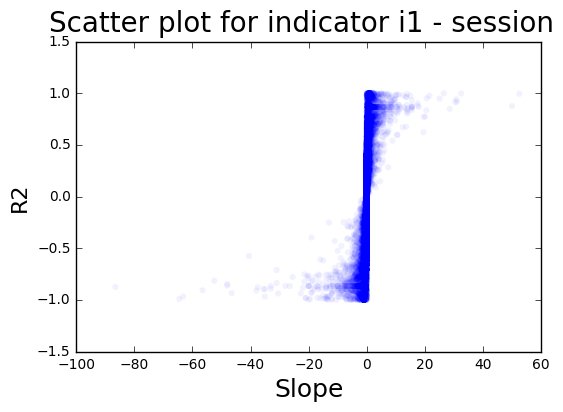

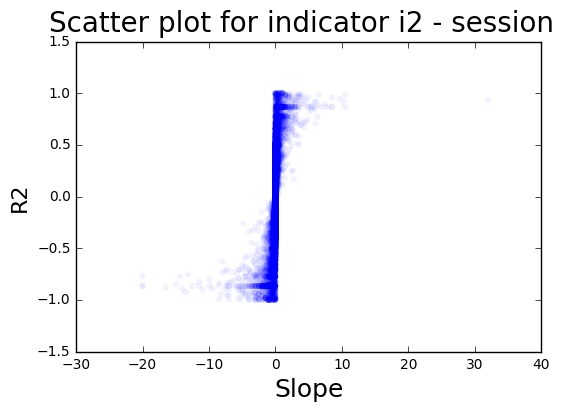

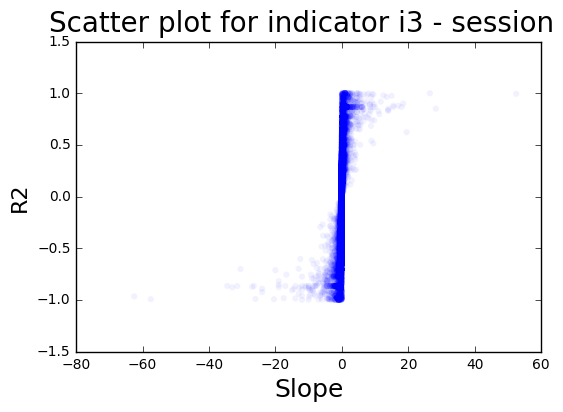

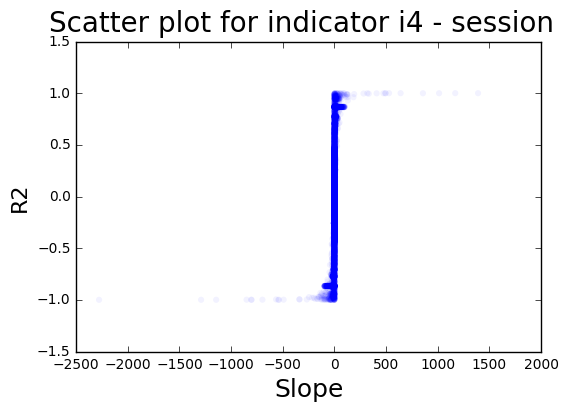

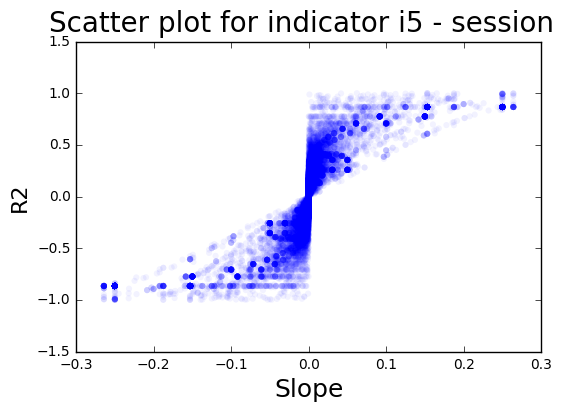

In [451]:
scatterplotindicator('i1',sessionransac,'session')
scatterplotindicator('i2',sessionransac,'session')
scatterplotindicator('i3',sessionransac,'session')
scatterplotindicator('i4',sessionransac,'session')
scatterplotindicator('i5',sessionransac,'session')

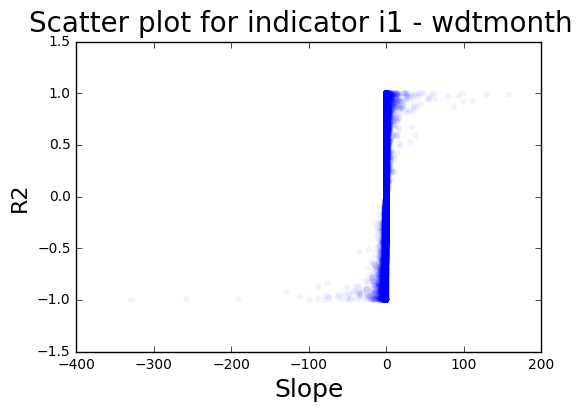

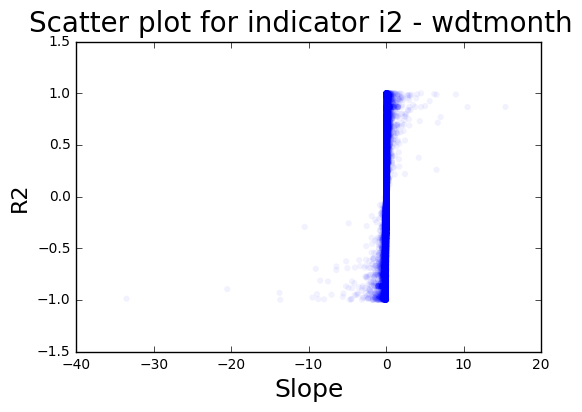

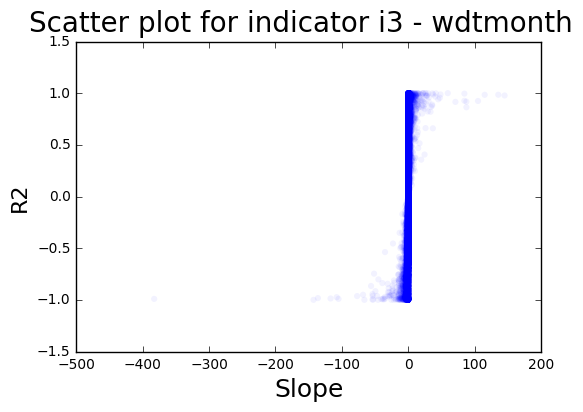

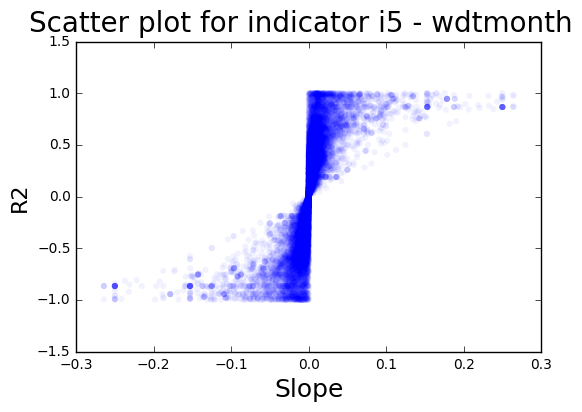

In [454]:
scatterplotindicator('i1',monthransac,'wdtmonth')
scatterplotindicator('i2',monthransac,'wdtmonth')
scatterplotindicator('i3',monthransac,'wdtmonth')
#scatterplotindicator('i4',monthransac,'wdtmonth')
scatterplotindicator('i5',monthransac,'wdtmonth')

In [455]:
from sklearn.cluster import KMeans
import numpy as np

In [468]:
def cluster_slopeandr2(i,data,clusters):
    datari = data.reset_index()
    # TODO: with CSV file too?
    isession = datari.loc[datari['level_0']==i]
   
    slopelog = isession['slope']#np.log(isession['slope'])
    r2log = isession['R2']#np.log(isession['R2'])
    
    df = pd.DataFrame()
    df['slope'] = slopelog
    df['R2'] = r2log
    
   
    dfwonannorinfinite = df.loc[(np.isfinite(df['slope'])) & (np.isfinite(df['R2'])) & df['slope'].notnull() & df['R2'].notnull() ]
    
    # debug
    #print(dfwonannorinfinite['slope'].dtypes)
    #print(dfwonannorinfinite['R2'].dtypes)
    #print(np.isnan(dfwonannorinfinite['slope']).sum())
    #print(np.isnan(dfwonannorinfinite['R2']).sum())
    #print(np.isinf(dfwonannorinfinite['slope']).sum())
    #print(np.isinf(dfwonannorinfinite['R2']).sum()) 
    print(len(dfwonannorinfinite['R2']))
    print(len(dfwonannorinfinite['slope']))
    # end of debug

    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(dfwonannorinfinite)
    kmeans.labels_
    #kmeans.predict([[0, 0], [4, 4]])
    #kmeans.cluster_centers_
    
    
    
    return kmeans,dfwonannorinfinite
    

In [469]:
kmeans_i1session,data_i1session = cluster_slopeandr2('i1',sessionransac,2)
kmeans_i2session,data_i2session  = cluster_slopeandr2('i2',sessionransac,2)
kmeans_i3session,data_i3session  = cluster_slopeandr2('i3',sessionransac,2)
kmeans_i4session,data_i4session  = cluster_slopeandr2('i4',sessionransac,2)
kmeans_i5session,data_i5session  = cluster_slopeandr2('i5',sessionransac,2)

46395
46395
46423
46423
46404
46404
40521
40521
46423
46423


In [470]:
kmeans_i1wdtmonth,data_i1wdtmonth = cluster_slopeandr2('i1',monthransac,2)
kmeans_i2wdtmonth,data_i2wdtmonth  = cluster_slopeandr2('i2',monthransac,2)
kmeans_i3wdtmonth,data_i3wdtmonth  = cluster_slopeandr2('i3',monthransac,2)
#kmeans_i4wdtmonth,data_i4wdtmonth  = cluster_slopeandr2('i4',monthransac,2)
kmeans_i5wdtmonth,data_i5wdtmonth  = cluster_slopeandr2('i5',monthransac,2)

36579
36579
36857
36857
36724
36724
36857
36857


In [471]:
labels_i1session = kmeans_i1session.labels_
print(labels_i1session)

print(data_i1session.head())

[0 0 0 ..., 0 0 0]
      slope        R2
0  0.001123  0.163024
1 -0.031655 -0.268520
2 -0.002030 -0.111575
3 -0.212024 -0.671347
5 -2.185714 -0.907010


df1 = pd.DataFrame(data_i1session.values)
df1.columns = ['slope','r2']
df2 = pd.DataFrame(labels_i1session)
df2.columns = ['kmeans_label']
i1session_toplot = pd.concat([df1,df2],axis=1,ignore_index=True) #


In [472]:
def plotclusters(kmeans_i,data_i):
    labels_i=kmeans_i.labels_
    plt.scatter(x=data_i['slope'], y=data_i['R2'], c=labels_i)

In [473]:
#labels_i1session=kmeans_i1session.labels_
#labels1 = labels_i1session[labels_i1session==1]
#labels0 = labels_i1session[labels_i1session==0]
#print(len(labels1))
#print(len(labels0))

46395
46395


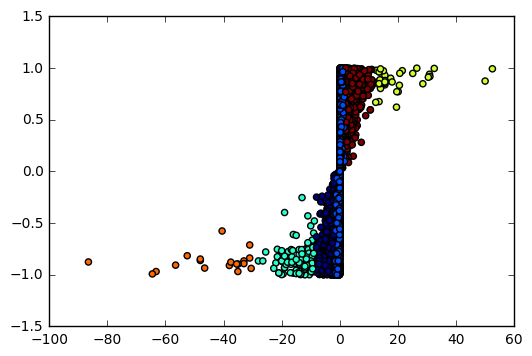

In [475]:
kmeans_i1session,data_i1session = cluster_slopeandr2('i1',sessionransac,6)
data_i1session.loc[(data_i1session[''])&()]
plotclusters(kmeans_i1session, data_i1session)


In [322]:
kmeans_i1wdtmonth  = cluster_slopeandr2('i1',monthransac,2)
kmeans_i2wdtmonth  = cluster_slopeandr2('i2',monthransac,2)
kmeans_i3wdtmonth  = cluster_slopeandr2('i3',monthransac,2)
#kmeans_i4wdtmonth  = cluster_slopeandr2('i4',monthransac,3)
kmeans_i5wdtmonth  = cluster_slopeandr2('i5',monthransac,2)

/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log
/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/alex/.virtualenvs/markov/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


16065
16065
13130
13130
15508
15508
14423
14423


In [ ]:
kmeans_i1session,data_i1session = cluster_slopeandr2('i1',sessionransac,6)
data_i1session.loc[(data_i1session[''])&()]
plotclusters(kmeans_i1session, data_i1session)

In [ ]:
## Survival

In [ ]:
#read files with revContributor

In [476]:
slope_r2_i1_s = pd.read_csv('slope_and_r2_i1_session.csv',usecols=[0,1,2],names=['slope','R2','revContributor'])
slope_r2_i2_s = pd.read_csv('slope_and_r2_i2_session.csv',usecols=[0,1,2],names=['slope','R2','revContributor'])
slope_r2_i3_s = pd.read_csv('slope_and_r2_i3_session.csv',usecols=[0,1,2],names=['slope','R2','revContributor'])
slope_r2_i4_s = pd.read_csv('slope_and_r2_i4_session.csv',usecols=[0,1,2],names=['slope','R2','revContributor'])
slope_r2_i5_s = pd.read_csv('slope_and_r2_i5_session.csv',usecols=[0,1,2],names=['slope','R2','revContributor'])

slope_r2_i1_m = pd.read_csv('slope_and_r2_i1_session.csv',usecols=[0,1,2],names=['slope','R2','revContributor'])
slope_r2_i2_m = pd.read_csv('slope_and_r2_i2_session.csv',usecols=[0,1,2],names=['slope','R2','revContributor'])
slope_r2_i3_m = pd.read_csv('slope_and_r2_i3_session.csv',usecols=[0,1,2],names=['slope','R2','revContributor'])
slope_r2_i4_m = pd.read_csv('slope_and_r2_i4_session.csv',usecols=[0,1,2],names=['slope','R2','revContributor'])
slope_r2_i5_m = pd.read_csv('slope_and_r2_i5_session.csv',usecols=[0,1,2],names=['slope','R2','revContributor'])



In [ ]:
def clean(slopedata):
    d = slopedata.loc[ slopedata['slope'].notnull() & df['R2'].notnull() ]
    

In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

def survivalAnalysis(df1,df2,label1,label2):
    T1 = df1['lifespan'] 
    E1 = df1['gone'] 
    
    T2 = df2['lifespan'] 
    E2 = df2['gone'] 
    
    kmf.fit(T1, E1, label=label1)
    ax = kmf.plot()

    kmf.fit(T2, E2, label=label2)
    kmf.plot(ax=ax)   


In [ ]:
survivalAnalysis(powerusers,weakusers,'powerusers','weakusers')

In [ ]:
## End of Survival

In [ ]:
    # slope-r2 to csv


# read and cluster

#X = np.array([[1, 2], [1, 4], [1, 0],
               [4, 2], [4, 4], [4, 0]])

